<a href="https://colab.research.google.com/github/YonDraco/learn-pyimagesearch/blob/master/pytorch_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

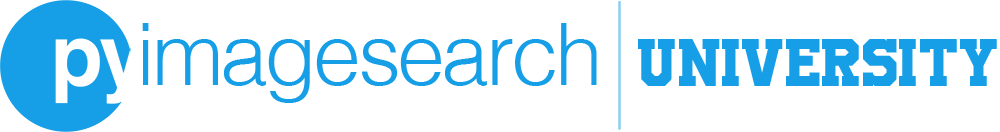

# PyTorch: Training your first Convolutional Neural Network (CNN)
### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch University](https://pyimg.co/university)** Jupyter Notebooks!

This notebook is associated with the [PyTorch: Training your first Convolutional Neural Network (CNN)](https://www.pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/) blog post published on 2021-07-19.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch University Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook. 

Happy hacking!

*Adrian*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2021 Adrian Rosebrock, PyimageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible by joining PyImageSearch University at https://pyimg.co/university today.*

### Download the code zip file

In [1]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/pytorch-cnn/pytorch-cnn.zip
!unzip -qq pytorch-cnn.zip
%cd pytorch-cnn

--2021-08-24 16:53:14--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/pytorch-cnn/pytorch-cnn.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.92.161.234
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.92.161.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1771768 (1.7M) [binary/octet-stream]
Saving to: ‘pytorch-cnn.zip’

pytorch-cnn.zip     100%[===================>]   1.69M  1.52MB/s    in 1.1s    

2021-08-24 16:53:16 (1.52 MB/s) - ‘pytorch-cnn.zip’ saved [1771768/1771768]

/content/pytorch-cnn


## Blog Post Code

### Import Packages

In [2]:
# import the necessary packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
from sklearn.metrics import classification_report
from torch.utils.data import random_split
from torch import flatten
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch
import time

### Implementing a Convolutional Neural Network (CNN) with PyTorch

In [3]:
class LeNet(Module):
	def __init__(self, numChannels, classes):
		# call the parent constructor
		super(LeNet, self).__init__()

		# initialize first set of CONV => RELU => POOL layers
		self.conv1 = Conv2d(in_channels=numChannels, out_channels=20,
			kernel_size=(5, 5))
		self.relu1 = ReLU()
		self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		# initialize second set of CONV => RELU => POOL layers
		self.conv2 = Conv2d(in_channels=20, out_channels=50,
			kernel_size=(5, 5))
		self.relu2 = ReLU()
		self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		# initialize first (and only) set of FC => RELU layers
		self.fc1 = Linear(in_features=800, out_features=500)
		self.relu3 = ReLU()

		# initialize our softmax classifier
		self.fc2 = Linear(in_features=500, out_features=classes)
		self.logSoftmax = LogSoftmax(dim=1)

	def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)

		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)

		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
		x = flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)

		# pass the output to our softmax classifier to get our output
		# predictions
		x = self.fc2(x)
		output = self.logSoftmax(x)

		# return the output predictions
		return output

### Creating our CNN training script with PyTorch


In [4]:
# define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10

# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT

# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# load the KMNIST dataset
print("[INFO] loading the KMNIST dataset...")
trainData = KMNIST(root="data", train=True, download=True,
	transform=ToTensor())
testData = KMNIST(root="data", train=False, download=True,
	transform=ToTensor())

# calculate the train/validation split
print("[INFO] generating the train/validation split...")
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numValSamples = int(len(trainData) * VAL_SPLIT)
(trainData, valData) = random_split(trainData,
	[numTrainSamples, numValSamples],
	generator=torch.Generator().manual_seed(42))

[INFO] loading the KMNIST dataset...


  0%|          | 0/18165135 [00:00<?, ?it/s]

Extracting data/KMNIST/raw/train-images-idx3-ubyte.gz to data/KMNIST/raw



  0%|          | 0/29497 [00:00<?, ?it/s]

Extracting data/KMNIST/raw/train-labels-idx1-ubyte.gz to data/KMNIST/raw



  0%|          | 0/3041136 [00:00<?, ?it/s]

Extracting data/KMNIST/raw/t10k-images-idx3-ubyte.gz to data/KMNIST/raw



  0%|          | 0/5120 [00:00<?, ?it/s]

Extracting data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to data/KMNIST/raw

[INFO] generating the train/validation split...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True,
	batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

In [7]:
# initialize the LeNet model
print("[INFO] initializing the LeNet model...")
model = LeNet(
	numChannels=1,
	classes=len(trainData.dataset.classes)).to(device)

# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=INIT_LR)
lossFn = nn.NLLLoss()

# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}

[INFO] initializing the LeNet model...


In [8]:
# measure how long training is going to take
print("[INFO] training the network...")
startTime = time.time()

# loop over our epochs
for e in range(0, EPOCHS):
	# set the model in training mode
	model.train()

	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0

	# initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0
	valCorrect = 0

	# loop over the training set
	for (x, y) in trainDataLoader:
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))

		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = lossFn(pred, y)

		# zero out the gradients, perform the backpropagation step,
		# and update the weights
		opt.zero_grad()
		loss.backward()
		opt.step()

		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y).type(
			torch.float).sum().item()

	# switch off autograd for evaluation
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()

		# loop over the validation set
		for (x, y) in valDataLoader:
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))

			# make the predictions and calculate the validation loss
			pred = model(x)
			totalValLoss += lossFn(pred, y)

			# calculate the number of correct predictions
			valCorrect += (pred.argmax(1) == y).type(
				torch.float).sum().item()

	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps

	# calculate the training and validation accuracy
	trainCorrect = trainCorrect / len(trainDataLoader.dataset)
	valCorrect = valCorrect / len(valDataLoader.dataset)

	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["train_acc"].append(trainCorrect)
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())
	H["val_acc"].append(valCorrect)

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
		avgTrainLoss, trainCorrect))
	print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
		avgValLoss, valCorrect))

# finish measuring how long training took
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[INFO] EPOCH: 1/10
Train loss: 0.360728, Train accuracy: 0.8878
Val loss: 0.133703, Val accuracy: 0.9602

[INFO] EPOCH: 2/10
Train loss: 0.101294, Train accuracy: 0.9698
Val loss: 0.110234, Val accuracy: 0.9673

[INFO] EPOCH: 3/10
Train loss: 0.059479, Train accuracy: 0.9821
Val loss: 0.087819, Val accuracy: 0.9759

[INFO] EPOCH: 4/10
Train loss: 0.038592, Train accuracy: 0.9880
Val loss: 0.079176, Val accuracy: 0.9777

[INFO] EPOCH: 5/10
Train loss: 0.026311, Train accuracy: 0.9916
Val loss: 0.087875, Val accuracy: 0.9749

[INFO] EPOCH: 6/10
Train loss: 0.019483, Train accuracy: 0.9936
Val loss: 0.072700, Val accuracy: 0.9811

[INFO] EPOCH: 7/10
Train loss: 0.016337, Train accuracy: 0.9946
Val loss: 0.076347, Val accuracy: 0.9817

[INFO] EPOCH: 8/10
Train loss: 0.012483, Train accuracy: 0.9957
Val loss: 0.076776, Val accuracy: 0.9823

[INFO] EPOCH: 9/10
Train loss: 0.009426, Train accuracy: 0.9968
Val loss: 0.099429, Val accuracy: 0.9791

[INFO] EPOCH: 10/10
Train loss: 0.010582, Trai

In [9]:
# we can now evaluate the network on the test set
print("[INFO] evaluating network...")

# turn off autograd for testing evaluation
with torch.no_grad():
	# set the model in evaluation mode
	model.eval()
	
	# initialize a list to store our predictions
	preds = []

	# loop over the test set
	for (x, y) in testDataLoader:
		# send the input to the device
		x = x.to(device)

		# make the predictions and add them to the list
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())

# generate a classification report
print(classification_report(testData.targets.cpu().numpy(),
	np.array(preds), target_names=testData.classes))

[INFO] evaluating network...
              precision    recall  f1-score   support

           o       0.94      0.97      0.95      1000
          ki       0.98      0.93      0.95      1000
          su       0.94      0.92      0.93      1000
         tsu       0.96      0.97      0.97      1000
          na       0.94      0.94      0.94      1000
          ha       0.95      0.96      0.95      1000
          ma       0.94      0.97      0.95      1000
          ya       0.98      0.94      0.96      1000
          re       0.93      0.97      0.95      1000
          wo       0.96      0.95      0.96      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



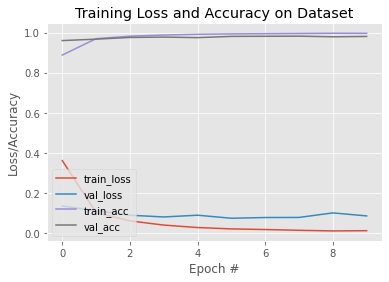

In [10]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [11]:
# serialize the model to disk
torch.save(model, "model.pth")